<a href="https://colab.research.google.com/github/pinakm9/symmetric_attractor/blob/master/notebooks/symmetric_attractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required modules**

In [1]:
# run this cell to download data and necessary modules
import os, shutil
repo = 'symmetric_attractor'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/symmetric_attractor.git
# add modules folder to Python's search path
import sys
sys.path.insert(0, repo + '/modules')
# import the necessary modules
import numpy as np
import tensorflow as tf
import lss_solver as lss
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Cloning into 'symmetric_attractor'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 54 (delta 5), reused 19 (delta 5), pack-reused 33
Unpacking objects: 100% (54/54), done.


**Define the equation through the $\mathcal L_{\log}$ operator**

In [2]:
DTYPE = tf.float32
dim = 3
ones = np.ones(dim)
domain = [-6. * ones, 6. * ones]
save_folder = '{}/data/'.format(repo)
sigma = 0.5
D = sigma**2 / 2.0
b = 0.208186

@tf.function
def diff_log_op(f, x, y, z):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, z])
        f_ = f(x, y, z)
        f_x, f_y, f_z = tape.gradient(f_, [x, y, z])
    f_xx = tape.gradient(f_x, x)
    f_yy = tape.gradient(f_y, y)
    f_zz = tape.gradient(f_z, z)

    p = tf.sin(y) - b*x
    q = tf.sin(z) - b*y 
    r = tf.sin(x) - b*z

    return -(p*f_x + q*f_y + r*f_z) + 3.*b  + D*(f_x**2 + f_y**2 + f_z**2 + f_xx + f_yy + f_zz) 

**Set up experiment parameters and learn the stationary distribution**

In [3]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 10000, 50000, 100000], [5e-3, 1e-3, 5e-4, 1e-4, 8e-5, 5e-5])
optimizer = tf.keras.optimizers.Adam(learning_rate)
solver = lss.LogSteadyStateSolver(num_nodes=50, num_blocks=3, dtype=DTYPE, name='thomas'.format(dim), diff_log_op=diff_log_op, optimizer=optimizer, domain=domain)
solver.learn(epochs = 20000, n_sample = 1000, save_folder=save_folder)

 Epoch        Loss        Runtime(s)
     0    0.451055            6.2530
    10    0.098375            6.4430
    20    0.076839            6.6455
    30    0.058225            6.8408
    40    0.050865            7.0346
    50    0.048489            7.2368
    60    0.043745            7.4219
    70    0.041127            7.6102
    80    0.035067            7.8022
    90    0.033101            7.9872
   100    0.035329            8.1836
   110    0.035043            8.3763
   120    0.035609            8.5663
   130    0.030613            8.7558
   140    0.032455            8.9428
   150    0.030401            9.1347
   160    0.026014            9.3368
   170    0.030638            9.5262
   180    0.030980            9.7197
   190    0.026790            9.9050
   200    0.027689           10.0944
   210    0.027812           10.2886
   220    0.026446           10.4859
   230    0.026898           10.6897
   240    0.025514           10.8828
   250    0.028442           11.0821
 

**Visualize the learned distribution**

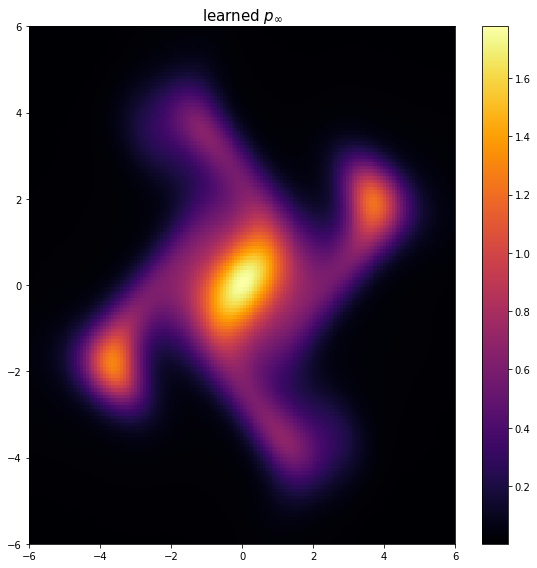

In [4]:
import matplotlib.pyplot as plt

def plot_solutions(learned, resolution=150, low=[-6., -6.], high=[6., 6.]):
  fig = plt.figure(figsize=(8, 8))
  ax_l = fig.add_subplot(111)
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True)
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True)
  x, y = np.meshgrid(x, y)
  z_l = learned(x.reshape(-1 ,1), y.reshape(-1, 1)).numpy()
  grid = (resolution, resolution)
  z_l = z_l.reshape(grid)
  im = ax_l.pcolormesh(x, y, z_l, cmap='inferno', shading='auto')
  fig.colorbar(im)
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()
  

plot_solutions(learned=lambda x, y: tf.exp(solver.net(x, y, 0. * np.ones_like(x))))

**Visulaize the noramlized learned solution**

In [5]:
x, y = solver.sampler(n_sample=10000, domain=[-3. * ones, 3. * ones])
Z_mc = 6**2 * tf.reduce_mean(tf.exp(solver.net(x, y))).numpy()
plot_solutions(learned=lambda *args: tf.exp(solver.net(*args)) / Z_mc, true=p_inf)

ValueError: ignored

**Investigate the size of $θ$**

In [ ]:
solver.net.summary()